### Neural Machine Translation using seq2seq

In [0]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input,LSTM,GRU,Dense,Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [0]:
# config variables
BATCH_SIZE = 64
EPOCHS = 100
LATENT_DIM = 256
NUM_SAMPLES = 10000
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [0]:
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

In [23]:
# load in the data
t = 0
for line in open('hin.txt'):
  t+=1
  if t>NUM_SAMPLES:
    break
  # input and target are seperated by '\t'
  if '\t' not in line:
    continue
  input_text, translation = line.split('\t')
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation
  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print('num samples:',len(input_texts))

num samples: 2808


In [0]:
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [25]:
# word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.'%len(word2idx_inputs))

Found 2388 unique input tokens.


In [0]:
# max length input seq
max_len_input = max(len(s) for s in input_sequences)

In [0]:
# tokenize the outputs
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [28]:
# word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.'%len(word2idx_outputs))

Found 3150 unique output tokens.


In [0]:
num_words_output = len(word2idx_outputs)+1

In [0]:
# max length output seq
max_len_target = max(len(s) for s in target_sequences)

In [31]:
# padding the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print('Encoder data shape:',encoder_inputs.shape)

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print('Decoder data shape:',decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

Encoder data shape: (2808, 22)
Decoder data shape: (2808, 26)


In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [0]:
!unzip glove.6B.zip

In [34]:
# loading pre-trained word vectors
word2vec = {}
with open('glove.6B.%sd.txt'%EMBEDDING_DIM) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.'%len(word2vec))

Found 400000 word vectors.


In [0]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [0]:
# creating embedding layer
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_len_input,
                            trainable=False)

In [0]:
decoder_targets_one_hot = np.zeros((len(input_texts),
                                   max_len_target,
                                   num_words_output),dtype='float32')
for i,d in enumerate(decoder_targets):
  for t,word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1

In [0]:
# build the model
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LATENT_DIM, return_state=True, dropout=0.5)
encoder_outputs, h, c = encoder(x)

In [0]:
encoder_states = [h,c] # keeping state to pass into decoder

In [0]:
decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

In [0]:
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True,
                    dropout=0.5)
decoder_outputs,_,_ = decoder_lstm(decoder_inputs_x,
                                   initial_state=encoder_states)

In [0]:
decoder_dense = Dense(num_words_output,activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [0]:
model = Model([encoder_inputs_placeholder,decoder_inputs_placeholder],
              decoder_outputs)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [47]:
r = model.fit([encoder_inputs, decoder_inputs],decoder_targets_one_hot,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_split=0.2)

W0809 17:14:26.067476 140686793947008 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2246 samples, validate on 562 samples
Epoch 1/100
2246/2246 [==============================] - 8s 3ms/step - loss: 2.4608 - acc: 0.7127 - val_loss: 3.0289 - val_acc: 0.5837
Epoch 2/100
2246/2246 [==============================] - 5s 2ms/step - loss: 1.6007 - acc: 0.7502 - val_loss: 2.8341 - val_acc: 0.5897
Epoch 3/100
2246/2246 [==============================] - 5s 2ms/step - loss: 1.4841 - acc: 0.7723 - val_loss: 2.7382 - val_acc: 0.6254
Epoch 4/100
2246/2246 [==============================] - 5s 2ms/step - loss: 1.4160 - acc: 0.7772 - val_loss: 2.6587 - val_acc: 0.6305
Epoch 5/100
2246/2246 [==============================] - 5s 2ms/step - loss: 1.3633 - acc: 0.7828 - val_loss: 2.6656 - val_acc: 0.6333
Epoch 6/100
2246/2246 [==============================] - 5s 2ms/step - loss: 1.3132 - acc: 0.7880 - val_loss: 2.6709 - val_acc: 0.6361
Epoch 7/100
2246/2246 [==============================] - 5s 2ms/step - loss: 1.2697 - acc: 0.7915 - val_loss: 2.6460 - val_acc: 0.6379
Epoch 8/

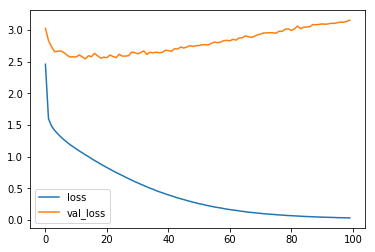

In [48]:
# plot the results
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

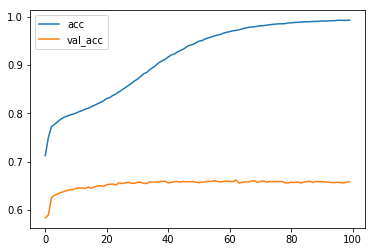

In [49]:
plt.plot(r.history['acc'],label='acc')
plt.plot(r.history['val_acc'],label='val_acc')
plt.legend()
plt.show()

In [0]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [0]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [0]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x,
                                     initial_state=decoder_states_inputs)

In [0]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [0]:
decoder_model = Model([decoder_inputs_single]+decoder_states_inputs,
                      [decoder_outputs]+decoder_states)

In [0]:
# mapping indices back to words
idx2word_eng = {v:k for k,v in word2idx_inputs.items()}
idx2word_trans = {v:k for k,v in word2idx_outputs.items()}

In [0]:
def decode_sequence(input_seq):
  states_value = encoder_model.predict(input_seq)
  # generating empty target seq of len 1
  target_seq = np.zeros((1,1))
  target_seq[0,0] = word2idx_outputs['<sos>']
  
  eos = word2idx_outputs['<eos>']
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens,h,c = decoder_model.predict([target_seq]+states_value)
    
    idx = np.argmax(output_tokens[0,0,:])
    if eos == idx:
      break
    
    word = ''
    if idx>0:
      word = idx2word_trans[idx]
      output_sentence.append(word)
    
    target_seq[0,0] = idx
    states_value = [h,c]
    
  return ' '.join(output_sentence) 

In [60]:
i = np.random.choice(len(input_texts))
input_seq = encoder_inputs[i:i+1]
translation = decode_sequence(input_seq)
print('Input:',input_texts[i])
print('Translation:',translation)

Input: He rescued the child from the fire.
Translation: उसने बच्चे को आग से बचाया।

